In [19]:
import h5py
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Dense, Flatten, AveragePooling2D,ZeroPadding2D, MaxPooling2D
from tensorflow.keras.models import Model
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt



In [ ]:
def IdentityBlock(X,f , filters, training=True):
    F1, F2, F3 = filters
    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=f, strides=(1, 1), padding='same' , kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X
    


In [ ]:
def ConvBlock(X, f, filters, s=2, training=True):
    F1, F2, F3 = filters
    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer = glorot_uniform(seed=0),)(X)
    X = BatchNormalization(axis=3)(X,training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=f, strides=(1, 1), padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    X_shortcut = Conv2D(filters=F3, kernel_size=1, strides=(s,s), padding='valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape, classes=6):
    X_input = Input(input_shape) 

    #stage 1
    X = ZeroPadding2D(padding=(3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # stage 2
    X = ConvBlock(X, f=3, filters=[64, 64, 256], s=1)
    X = IdentityBlock(X, f=3, filters=[64, 64, 256])
    X = IdentityBlock(X, f=3, filters=[64, 64, 256])            
    
    # stage 3
    X = ConvBlock(X, f=3, filters=[128, 128, 512], s=2)
    X = IdentityBlock(X, f=3, filters=[128, 128, 512])
    X = IdentityBlock(X, f=3, filters=[128, 128, 512])
    X = IdentityBlock(X, f=3, filters=[128, 128, 512])      
    # stage 4
    X = ConvBlock(X, f=3, filters=[256, 256, 1024], s=2)
    X = IdentityBlock(X, f=3, filters=[256, 256, 1024])
    X = IdentityBlock(X, f=3, filters=[256, 256, 1024])
    X = IdentityBlock(X, f=3, filters=[256, 256, 1024])
    X = IdentityBlock(X, f=3, filters=[256, 256, 1024])
    X = IdentityBlock(X, f=3, filters=[256, 256, 1024])   

    #stage 5
    X = ConvBlock(X, f=3, filters=[512, 512, 2048], s=2)
    X = IdentityBlock(X, f=3, filters=[512, 512, 2048])
    X = IdentityBlock(X, f=3, filters=[512, 512, 2048]) 

    # AVGPOOL
    X = AveragePooling2D((2, 2), strides=(1, 1))(X)


    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X,)
    return model
       

In [5]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 29, 29,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 29, 29,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 29, 29,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 14, 14,    │          0 │ add[0][0]       

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
train_dataset = h5py.File(r'C:\Users\khale\ML\Residual Networks\dataset\train_signs.h5', "r")
X_train = np.array(train_dataset["train_set_x"][:])
y_train = np.array(
    train_dataset["train_set_y"][:])  # your train set labels

test_dataset = h5py.File(r'C:\Users\khale\ML\Residual Networks\dataset\test_signs.h5', "r")
# your test set features
X_test = np.array(test_dataset["test_set_x"][:])
y_test = np.array(
    test_dataset["test_set_y"][:])  # your test set labels

classes = np.array(test_dataset["list_classes"][:])  # the list of classes

y_train = y_train.reshape((1, y_train.shape[0]))
y_test = y_test.reshape((1, y_test.shape[0]))


In [8]:
y_train = np.eye(6)[y_train.reshape(-1)]
y_test = np.eye(6)[y_test.reshape(-1)]

X_train = X_train / 255.
X_test = X_test / 255.

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(1080, 64, 64, 3)
(1080, 6)
(120, 64, 64, 3)
(120, 6)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify=y_train)

In [16]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16,validation_data=(X_val, y_val))

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 288ms/step - accuracy: 0.8764 - loss: 0.4320 - val_accuracy: 0.3410 - val_loss: 8.8770
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 298ms/step - accuracy: 0.8115 - loss: 1.2156 - val_accuracy: 0.1618 - val_loss: 10256508.0000
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 284ms/step - accuracy: 0.6160 - loss: 1.8440 - val_accuracy: 0.1618 - val_loss: 106149.8594
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step - accuracy: 0.7230 - loss: 1.0369 - val_accuracy: 0.1618 - val_loss: 2519.3186
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - accuracy: 0.8337 - loss: 0.7432 - val_accuracy: 0.1792 - val_loss: 100.1191
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 288ms/step - accuracy: 0.8161 - loss: 0.9921 - val_accuracy: 0.4335 - val_loss: 4.2519
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step - accuracy: 0.8505 - loss: 0.5199 - val_accuracy: 0.1792 - val_loss: 7.9667
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step - accuracy: 0.8494 - loss: 

In [17]:
preds = model.evaluate(X_test, y_test)
print("Loss:", preds[0])
print("Accuracy:", preds[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9581 - loss: 0.1116
Loss: 0.13645198941230774
Accuracy: 0.949999988079071


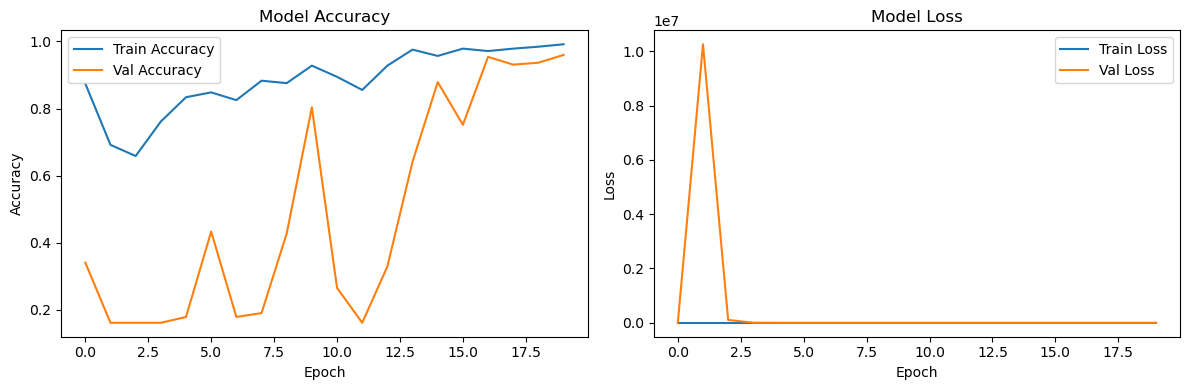

In [18]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step


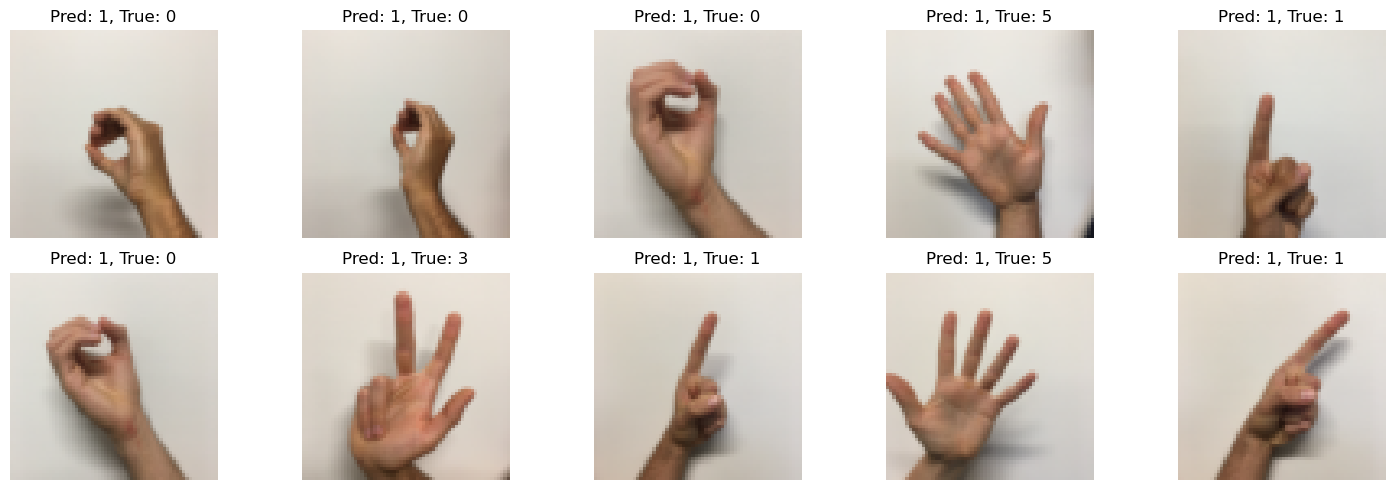

In [ ]:
preds = model.predict(X_test)  # shape: (120, 6)
predicted_labels = np.argmax(preds, axis=1)

true_labels = np.argmax(y_test, axis=1)

plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"Pred: {predicted_labels[i]}, True: {true_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
